In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
# 1. 텍스트 임베딩 및 감정 라벨 불러오기
df_text = pd.read_csv(r'C:\project_files\Multimodal_Auto _BGM_Addition_System\dataset_preprocessed\text\text_embeddings_with_labels_kobert.csv')
text_embeddings = df_text.iloc[:, :-1].values  # 텍스트 임베딩 (768차원)
text_labels = df_text['emotion_label'].values  # 감정 라벨

# 2. 이미지 임베딩 및 감정 라벨 불러오기
df_image = pd.read_csv(r'C:\project_files\Multimodal_Auto _BGM_Addition_System\dataset_preprocessed\image\image_embeddings_with_labels_768.csv')
image_embeddings = df_image.iloc[:, :-1].values  # 이미지 임베딩 (768차원)
image_labels = df_image['emotion_label'].values  # 감정 라벨

# 3. 오디오 임베딩 및 감정 라벨 불러오기
df_audio = pd.read_csv(r'C:\project_files\Multimodal_Auto _BGM_Addition_System\dataset_preprocessed\audio\audio_embeddings_with_labels.csv')
audio_embeddings = df_audio.iloc[:, :-1].values  # 오디오 임베딩 (768차원)
audio_labels = df_audio['emotion_label'].values  # 감정 라벨

# 4. Keras 모델의 입력 레이어 정의
text_input = layers.Input(shape=(text_embeddings.shape[1],), name="text_input")
image_input = layers.Input(shape=(image_embeddings.shape[1],), name="image_input")
audio_input = layers.Input(shape=(audio_embeddings.shape[1],), name="audio_input")

# 출력 확인
print(f"Text input shape: {text_input.shape}")
print(f"Image input shape: {image_input.shape}")
print(f"Audio input shape: {audio_input.shape}")


Text input shape: (None, 768)
Image input shape: (None, 768)
Audio input shape: (None, 768)


In [3]:
# Transformer Block 정의
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# 모달리티별 Transformer 적용 함수 정의
def apply_transformer(input_tensor, embed_dim, num_heads, ff_dim):
    # 768차원을 embed_dim(128)으로 변환
    x = layers.Dense(embed_dim)(input_tensor)  # 768 -> 128 차원 변환
    
    # 2D input을 3D로 변환 (batch_size, 1, embed_dim)
    x = layers.Reshape((1, embed_dim))(x)
    
    # Transformer Block 적용
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    
    # 3D를 다시 2D로 변환
    x = layers.Flatten()(x)
    return x

# Transformer 설정
embed_dim = 128  # Transformer 임베딩 차원
num_heads = 4  # Multi-head Attention에서 사용할 헤드 수
ff_dim = 128  # Feed-forward 레이어 차원

# 텍스트 모달리티에 Transformer 적용
text_features = apply_transformer(text_input, embed_dim, num_heads, ff_dim)

# 이미지 모달리티에 Transformer 적용
image_features = apply_transformer(image_input, embed_dim, num_heads, ff_dim)

# 오디오 모달리티에 Transformer 적용
audio_features = apply_transformer(audio_input, embed_dim, num_heads, ff_dim)

# 결과 출력
print(f"Text features shape: {text_features.shape}")
print(f"Image features shape: {image_features.shape}")
print(f"Audio features shape: {audio_features.shape}")

Text features shape: (None, 128)
Image features shape: (None, 128)
Audio features shape: (None, 128)


In [4]:
# 모달리티 결합 (Fusion)
concatenated_features = layers.Concatenate()([text_features, image_features, audio_features])

# Fully Connected Layer 적용
x = layers.Dense(256, activation="relu")(concatenated_features)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# 감정 분류 출력층 (Softmax 사용하여 6개의 감정 클래스로 분류)
output = layers.Dense(6, activation="softmax")(x)

# 최종 모델 정의
vatt_model = models.Model(inputs=[text_input, image_input, audio_input], outputs=output)

# 모델 컴파일
vatt_model.compile(optimizer='adam', 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

# 모델 요약 출력
vatt_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 image_input (InputLayer)       [(None, 768)]        0           []                               
                                                                                                  
 audio_input (InputLayer)       [(None, 768)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          98432       ['text_input[0][0]']             
                                                                                              

In [5]:
# 주어진 감정 라벨 매핑
# emotion_label_mapping = {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sad': 4, 'surprise': 5}

# 이미지, 오디오 데이터의 샘플 수 확인 (가장 작은 샘플 수로 맞출 계획)
min_samples = min(image_embeddings.shape[0], audio_embeddings.shape[0])  # 1980 샘플 기준

# 1. 텍스트 데이터에서 무작위로 min_samples 수만큼 샘플링
np.random.seed(42)  # 재현성을 위해 랜덤 시드 설정
indices_text = np.random.choice(text_embeddings.shape[0], min_samples, replace=False)  # 1980개 샘플 추출
text_embeddings_sampled = text_embeddings[indices_text]
text_labels_sampled = text_labels[indices_text]  # 해당 텍스트 레이블도 동일하게 추출

# 2. 오디오 데이터에서 무작위로 min_samples 수만큼 샘플링
indices_audio = np.random.choice(audio_embeddings.shape[0], min_samples, replace=False)  # 1980개 샘플 추출
audio_embeddings_sampled = audio_embeddings[indices_audio]

# 감정 라벨은 이미 숫자로 되어 있으므로 그대로 사용
y_labels = text_labels_sampled

# 3. 학습 데이터와 테스트 데이터로 분할 (텍스트, 이미지, 오디오의 샘플 수를 동일하게 맞췄습니다)
x_train_text, x_test_text, y_train, y_test = train_test_split(text_embeddings_sampled, y_labels, test_size=0.2, random_state=42)
x_train_image, x_test_image, _, _ = train_test_split(image_embeddings, y_labels, test_size=0.2, random_state=42)
x_train_audio, x_test_audio, _, _ = train_test_split(audio_embeddings_sampled, y_labels, test_size=0.2, random_state=42)

# 4. 감정 라벨을 one-hot encoding으로 변환
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

In [6]:
# 2. 모델 학습

# 모델 학습 (이전 단계에서 작성한 vatt_model 사용)
history = vatt_model.fit(
    [x_train_text, x_train_image, x_train_audio],  # 3개의 모달리티 입력
    y_train,  # 레이블
    epochs=20,  # 학습 에포크 수
    batch_size=32,  # 배치 크기
    validation_split=0.2  # 검증 데이터로 20% 사용
)


Epoch 1/20
40/40 [==============================] - 2s 17ms/step - loss: 2.0312 - accuracy: 0.1863 - val_loss: 1.7999 - val_accuracy: 0.1861
Epoch 2/20
40/40 [==============================] - 0s 10ms/step - loss: 1.8371 - accuracy: 0.1665 - val_loss: 1.7829 - val_accuracy: 0.1893
Epoch 3/20
40/40 [==============================] - 0s 10ms/step - loss: 1.7965 - accuracy: 0.1871 - val_loss: 1.7954 - val_accuracy: 0.1767
Epoch 4/20
40/40 [==============================] - 0s 9ms/step - loss: 1.7965 - accuracy: 0.2052 - val_loss: 1.7810 - val_accuracy: 0.2145
Epoch 5/20
40/40 [==============================] - 0s 10ms/step - loss: 1.7708 - accuracy: 0.2305 - val_loss: 1.7878 - val_accuracy: 0.2082
Epoch 6/20
40/40 [==============================] - 0s 10ms/step - loss: 1.7507 - accuracy: 0.2391 - val_loss: 1.7989 - val_accuracy: 0.1767
Epoch 7/20
40/40 [==============================] - 0s 10ms/step - loss: 1.7234 - accuracy: 0.2518 - val_loss: 1.8239 - val_accuracy: 0.1514
Epoch 8/20
40/

In [7]:
# 3. 모델 평가

# 테스트 데이터로 모델 성능 평가
test_loss, test_accuracy = vatt_model.evaluate(
    [x_test_text, x_test_image, x_test_audio],  # 3개의 모달리티 입력
    y_test  # 레이블
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

13/13 [==============================] - 0s 4ms/step - loss: 2.3434 - accuracy: 0.1742
Test Loss: 2.3433678150177
Test Accuracy: 0.17424242198467255


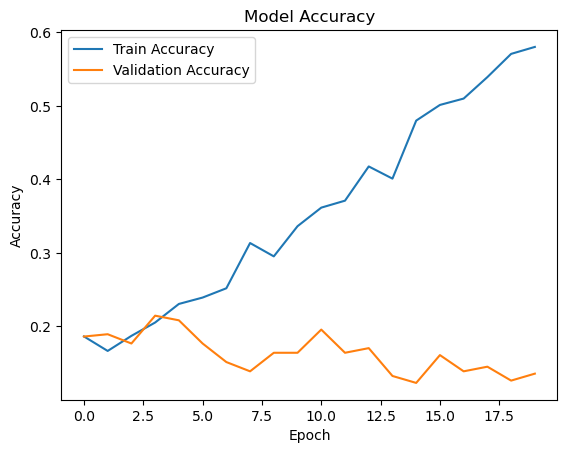

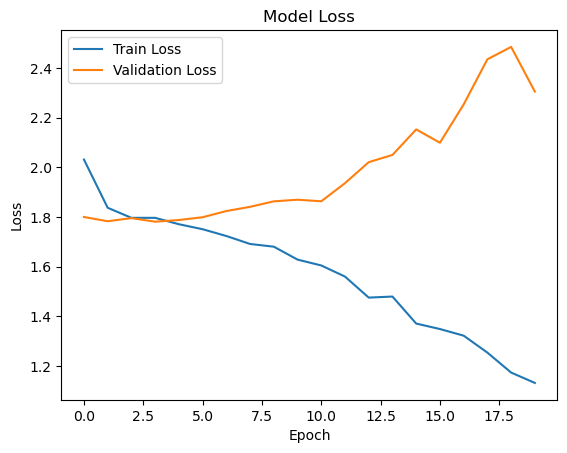

In [8]:
# 4. 학습 과정 시각화


# 학습 정확도 및 손실 그래프 그리기
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()